<a href="https://colab.research.google.com/github/TeachingTextMining/TextClassification/blob/main/02-SA-Transformers-Basic/02_TextClassification_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de textos utilizando Transformers

La clasificación de textos consiste en, dado un texto, asignarle una entre varias categorías. Algunos ejemplos de esta tarea son:

- dado un tweet, categorizar su connotación como positiva, negativa o neutra.
- dado un post de Facebook, clasificarlo como portador de un lenguaje ofensivo o no.  

En la actividad exploraremos cómo utilizar soluciones *out of the box* para esta tarea incluidas en la librería [Transformers](https://huggingface.co/transformers/) y su aplicación para clasificar reviews de [IMDB](https://www.imdb.com/) sobre películas en las categorías \[$positive$, $negative$\]. 

Puede encontrar más información sobre este problema en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) y en [Large Movie Review Datase](http://ai.stanford.edu/~amaas/data/sentiment/).

**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.


**Después de esta actividad nos habremos familiarizado con:**
- seleccionar e instanciar modelos pre-entrenados para realizar clasificación de textos.
- cómo instanciar un pipeline para la clasificación de textos utilizando la librería Transformers.
- utilizar este pipeline para clasificar nuevos textos.

**Requerimientos**
- python 3.6.12 - 3.8
- tensorflow==2.3.0
- transformers==4.2.1
- pandas==1.1.5
- plotly==4.13.0
- tqdm==4.56.0
- scikit-learn==0.24.0

### Instalación de librerías e importación de dependencias.

Para comenzar, es preciso instalar las dependencias y realizar los imports necesarios.

Ejecute las siguientes casillas prestando atención a las instrucciones adicionales en los comentarios.

In [3]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow==2.3.0, etc. que en este caso se encontrarían ya instaladas
%%capture
!pip install transformers==4.2.1

print('Done!')

In [4]:
# para cargar datos y realizar pre-procesamiento básico
import pandas as pd
from collections import Counter

# para evaluar los modelos 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
from tqdm import tqdm

# algoritmos de clasificación, tokenizadores, etc.
from transformers import TextClassificationPipeline, DistilBertTokenizer, TFDistilBertForSequenceClassification, ModelCard

from transformers.tokenization_utils import TruncationStrategy
print('Done!')

Done!


### Carga de datos y análisis exploratorio

El primer paso consiste en obtener los datos relacionados con nuestra tarea dejándolos en el formato adecuado.  Existen diferentes opciones, entre estas:

- montar nuestra partición de Google Drive y leer un fichero desde esta.

- leer los datos desde un fichero en una carpeta local.

- leer los datos directamente de un URL.

En este caso, se encuentran en un fichero separado por comas con la siguiente estructura:

| Phrase | Sentiment| 
| ------ | ------ |
| This movie is really not all that bad...    | positive |


Ejecute la siguiente casilla para leer los datos.



In [3]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive,sumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'


# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'


# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/02-SA-Transformers-Basic/sample_data/ejemplo_review_train.csv'


# leer los datos
data = pd.read_csv(path, sep=',')

print('Done!')

Done!


Una vez leídos los datos, ejecute la siguiente casilla para construir una gráfica que muestra la distribución de clases en el corpus.


In [4]:
# obtener algunas estadísticas sobre los datos
categories = sorted(data['Sentiment'].unique(), reverse=True)
hist= Counter(data['Sentiment']) 
print('Total de instancias -> {0}'.format(data.shape[0]))
print('Distribución de clases -> {0}'.format({item[0]:round(item[1]/len(data['Sentiment']), 3) for item in sorted(hist.items(), key=lambda x: x[0])}))

print('Categorías -> {0}'.format(categories))
print('Comentario de ejemplo -> {0}'.format(data['Phrase'][0]))
print('Categoría del comentario -> {0}'.format(data['Sentiment'][0]))

colors = ['darkgreen', 'red']
fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in sorted(hist.keys())], marker_color=colors))
fig.show()

print('Done!')

Total de instancias -> 1763
Distribución de clases -> {'negative': 0.511, 'positive': 0.489}
Categorías -> ['positive', 'negative']
Comentario de ejemplo -> This is a great movie that everyone should see. It plays like a Dean Koontz book.<br /><br />Bill Paxton's performance was great in that it really seems like he believes in what he is saying and doing.<br /><br />I don't know why viewers have to read in some kind of advocacy for religious murder in to the film. It is fiction. The ending is surprising, but fictional. So what? I think that is what makes this movie so good. SPOILER DO NOT READ FURTHER IF YOU HAVENT SEEN THE MOVIE. Throughout the movie, the viewer is continually shocked at the sickness of Paxton's character, the impact on the children, and the way the children handle this outrageous conduct. And then at the end, it turns out to be true. God has put him on a mission to rid the world of demons. Paxton is not clairvoyant as other viewers suggest. Sure, he is given info th

Done!


### Carga del modelo pre-entrenado
La librería Transformers provee diferentes modelos listos para usar en la tarea de clasificación de textos. Una forma flexible de lograrlo consiste en:

- seleccionar un modelo pre-entrenado adecuado para la tarea. Podemos examinar los modelos disponibles en [https://huggingface.co/models](https://huggingface.co/models). Estaremos utilizando el llamado [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) que permite clasificar un texto en idioma inglés de acuerdo con su connotación **positiva** o **negativa**.

- instanciar el modelo y su correspondiente tokenizador.

- crear un pipeline para la clasificación de textos, en este caso utilizando la clase [TextClassificationPipeline](https://huggingface.co/transformers/main_classes/pipelines.html#transformers.TextClassificationPipeline).

- utilizar el pipeline para clasificar textos.


Ejecute la siguiente celda para instanciar el modelo y el correspondiente tokenizador.

**Note que:**
- la práctica recomendada al crear un nuevo modelo para Transformers es hacerlo disponible mediante un fichero que contiene los elementos necesarios para su posterior uso, como son el modelo, el tokenizador y una tarjeta con metadatos sobre el modelo. 

- es conveniente indagar sobre el modelo base utilizado, en este caso **DistilBert**, esto permitirá seleccionar las clases adecuadas para instanciar el modelo.


In [5]:
# configuraciones
trained_model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
max_length = 512    # máxima longitud de secuencia recomendada por DistilBERT

# cargar el tokenizador, disponible en Transformers. Establecer model_max_length para cuando el tokenizador sea llamado, trunque automáticamente.
tokenizer = DistilBertTokenizer.from_pretrained(trained_model_name, model_max_length=max_length)

# cargar el modelo, disponible en Transformers
model = TFDistilBertForSequenceClassification.from_pretrained(trained_model_name)
modelcard = ModelCard.from_pretrained(trained_model_name)

print('Done!')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Done!


Una vez instanciado el modelo y el tokenizador, instanciamos el pipeline de clasificación de textos. 

Ejecute la siguiente celda para crear una instancia de TextClassificationPipeline a partir del modelo y tokenizador.

In [6]:
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, modelcard=None, framework='tf', task='sentiment-analysis', return_all_scores=False)

print('Done!')

Done!


Ejecute la siguiente celda para clasificar una la frase. Alternativamente, puede modificar el texto incluyendo uno de su preferencia. Recuerde que debe ser en idioma inglés.

In [7]:
text = "Natural Language Processing is a very interesting subject."
output = classifier(text, truncation=TruncationStrategy.ONLY_FIRST)
print(output)

print('Done!')

[{'label': 'POSITIVE', 'score': 0.9997135400772095}]
Done!


### Evaluación del modelo

En este caso no ha sido necesario entrenar el modelo, no obstante, lo evaluaremos en un conjunto reviews para los que se conoce su categoría de modo que podamos estimar el desempeño en nuevos datos.

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de entrenamiento.

**Notar que:**

- la salida del modelo es un diccionario con 'label' y 'score'. Debemos formatearla para poder comparar con los valores de referencia.

- para evitar problemas relacionados con el consumo de memoria, se realizará la predicción de instancias por lotes. Además se utilizará TruncationStrategy.ONLY_FIRST para indicar al pipeline que trunque las secuencias con longitud mayor a la recomendada por el modelo.

100%|██████████| 10/10 [23:12<00:00, 139.20s/it]


==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88       901
    positive       0.90      0.85      0.87       862

    accuracy                           0.88      1763
   macro avg       0.88      0.88      0.88      1763
weighted avg       0.88      0.88      0.88      1763

Accuracy -> 87.92%
==== Matriz de confusión ==== 
Done!


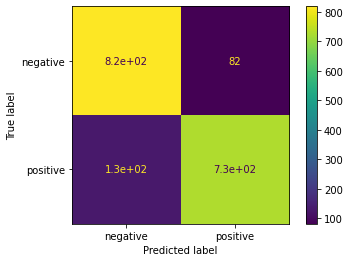

In [8]:
# configuraciones
batch_size = 192 # puede indicar un valor menor para disminuir el consumo de memoria 
size = data.shape[0]

# predecir los datos de entrenamiento
pred_labels = []
for i in tqdm(range(0, size, batch_size)):
    batch_text = data['Phrase'][i:i+batch_size].to_list()
    batch_labels = classifier(batch_text, truncation=TruncationStrategy.ONLY_FIRST)
    batch_labels = [pred['label'].lower() for pred in batch_labels]
    pred_labels.extend(batch_labels)

target_labels = data['Sentiment']

print('==== Sumario de la clasificación ==== ')
print(classification_report(target_labels, pred_labels))

print('Accuracy -> {:.2%}'.format(accuracy_score(target_labels, pred_labels)))

print('==== Matriz de confusión ==== ')
cm = confusion_matrix(target_labels, pred_labels)
display_labels = unique_labels(target_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
disp.plot(include_values=True)

print('Done!')

### Predicción de nuevos datos
Una vez evaluado el modelo para estimar su rendimiento en nuestro problema, podemos utilizarlo para predecir nuevos datos. En el ejemplo, utilizaremos la porción de prueba preparada inicialmente.

Ejecute la siguiente casilla para cargar los datos, descomentando las instrucciones necesarias según sea el caso.

In [8]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive,sumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'


# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'


# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/02-SA-Transformers-Basic/sample_data/ejemplo_review_test.csv'


# leer los datos
new_data = pd.read_csv(path, sep=',')

print('Done!')

Done!


Ejecute la siguiente celda para clasificar los textos. Tenga en cuenta que, en dependencia del entorno de ejecución, la cantidad de textos y su longitud, la ejecución puede tardar varios minutos o requerir una cantidad de memoria no disponible.

In [9]:
# configuraciones
batch_size = 192 # puede indicar un valor menor para disminuir el consumo de memoria 
size = new_data.shape[0]

# predecir los datos de entrenamiento
pred_labels = []
for i in tqdm(range(0, size, batch_size)):
    batch_text = new_data['Phrase'][i:i+batch_size].to_list()
    batch_labels = classifier(batch_text, truncation=TruncationStrategy.ONLY_FIRST)
    batch_labels = [pred['label'].lower() for pred in batch_labels]
    pred_labels.extend(batch_labels)


# obtener algunas estadísticas sobre la predicción en el conjunto de pruebas
categories = ['positive', 'negative']
hist = Counter(pred_labels) 

colors = ['darkgreen', 'red']
fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in sorted(hist.keys())], marker_color=colors))
fig.show()

print('Done!')

100%|██████████| 2/2 [02:44<00:00, 82.25s/it] 


Done!
